In [83]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import tqdm
import glob
import subprocess
import multiprocessing
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

# Functions

In [2]:
import xrft
import subprocess

def fourier_truncate(ds,truncate=0.3):
    
    """
    Spectral truncation of data using FT.
    truncate = truncation level in maximum allowed frequency per degree
    """
    
    # fft
    ds_fft = xrft.fft(ds,dim=['latitude','longitude'],true_phase=True,true_amplitude=True)

    # truncate
    ds_fft = ds_fft.where(np.sqrt(ds_fft.freq_longitude**2+ds_fft.freq_latitude**2)<truncate,0)

    # invert
    ds_ifft = xrft.ifft(ds_fft,dim=['freq_longitude','freq_latitude'],true_phase=True,true_amplitude=True)

    return ds_ifft


def truncate_and_save(fpath,add_msl=True, base_dir='/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/'):
    '''
    Function to truncate and save data for Tempest Extremes 
    storm tracking.
    Written by Nick Leach.

    Parameters
    ----------  
    fpath : str
        Path to the data file.
    add_msl : bool
        If True, the function will also load the mean sea level pressure data.  
    base_dir : str
        Path to the directory where the data will be saved.

    Returns
    -------
    None
    '''
    
    ds_fname = fpath.split('/')[-1].split('.')[0]
    
    ds = xr.open_dataset(fpath)
    print('loaded pl data',flush=True)
    ds = ds.vo.sel(level=850,time=(ds.time.dt.hour%3)==0)
    ds = ds.sel(time=slice('2023-10-11','2023-10-23'))
    print('truncating vo data',flush=True)
    ds_trunc = fourier_truncate(ds).sortby('latitude',ascending=False)
    print('truncated vo data',flush=True)
    
    if add_msl:
        ds = xr.open_dataset(fpath.replace('/pl/','/sfc/')).get(['msl'])
        ds = ds.sel(time=ds_trunc.time)
        print('loaded msl data',flush=True)
        
        if 'number' in ds.coords:
            ds['vo'] = (('time','number','latitude','longitude'),ds_trunc.real.values)
            print('saving member files',flush=True)
            [ds.sel(number=x).to_netcdf(base_dir+'TEin_{}_{}.nc'.format(ds_fname,x)) for x in ds.number.values]
            in_paths = [base_dir+'TEin_{}_{}.nc'.format(ds_fname,x) for x in ds.number.values]
        else:
            ds['vo'] = (('time','latitude','longitude'),ds_trunc.real.values)
            print('saving control file',flush=True)
            ds.to_netcdf(base_dir+'TEin_{}_{}.nc'.format(ds_fname,0))
            in_paths = [base_dir+'TEin_{}_{}.nc'.format(ds_fname,0)]
    else:
        if 'number' in ds.coords:
            [ds_trunc.real.sel(number=x).to_netcdf(base_dir+'TEin_{}_{}.nc'.format(ds_fname,x)) for x in ds.number.values]
            in_paths = [base_dir+'TEin_{}_{}.nc'.format(ds_fname,x) for x in ds.number.values]
        else:
            ds_trunc.real.to_netcdf(base_dir+'TEin_{}_{}.nc'.format(ds_fname,0))
            in_paths = [base_dir+'TEin_{}_{}.nc'.format(ds_fname,0)]
                
    with open(base_dir+'TE_nc_in_list.txt','w') as f:
        f.writelines([x+'\n' for x in in_paths])
    with open(base_dir+'TE_DN_out.txt','w') as f:
        f.writelines([x.replace('TEin','TENodes').replace('.nc','')+'\n' for x in in_paths])
        

def run_TE(fpath, base_dir='/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/'):
    '''
    Function to run Tempest Extremes storm tracking.
    Written by Nick Leach.

    Parameters
    ----------
    fpath : str
        Path to the data file.
    base_dir : str
        Path to the directory where the data will be saved.

    Returns
    -------
    None
    '''
    
    truncate_and_save(fpath)
    
    print('Node detection across files',flush=True)

    DetectNodes_args = []
    DetectNodes_args += ['DetectNodes']
    DetectNodes_args += ['--in_data_list', base_dir+'TE_nc_in_list.txt']
    DetectNodes_args += ['--out_file_list', base_dir+'TE_DN_out.txt']
    DetectNodes_args += ['--closedcontourcmd','msl,300,6.0,0']
    DetectNodes_args += ['--thresholdcmd','vo,>,0.0002,4.0']
    DetectNodes_args += ['--mergedist','2.0']
    DetectNodes_args += ['--searchbymin','msl']
    DetectNodes_args += ['--outputcmd','msl,min,3;vo,max,0']
    DetectNodes_args += ['--timefilter','6hr'] # previously 3h
    DetectNodes_args += ['--latname','latitude']
    DetectNodes_args += ['--lonname','longitude']
    DetectNodes_args += ['--regional']
    
    DN_out = subprocess.run(DetectNodes_args,stdout=subprocess.PIPE)
    
    print('Node stitching across files',flush=True)

    with open(base_dir+'TE_DN_out.txt','r') as f:
        nodefiles = [x.strip() for x in f.readlines()]
        
    for nodefile in nodefiles:
    
        StitchNodes_args = []
        StitchNodes_args += ['StitchNodes']

        StitchNodes_args += ['--in_fmt','lon,lat,msl,vo']
        StitchNodes_args += ['--in',nodefile]
        StitchNodes_args += ['--out',nodefile.replace('TENodes','TEStitch')]
        StitchNodes_args += ['--range','7.0']
        StitchNodes_args += ['--mintime','24h']
        StitchNodes_args += ['--maxgap','48h']
        StitchNodes_args += ['--min_endpoint_dist','12.0']
        StitchNodes_args += ['--out_file_format','csv']
    
        SN_out = subprocess.run(StitchNodes_args,stdout=subprocess.PIPE)


def read_nodes(fpath):
    '''
    Function to read in the nodes from the Tempest Extremes output.
    Written by Nick Leach.

    Parameters
    ----------
    fpath : str
        Path to the data file.

    Returns
    -------
    pd.DataFrame
        Dataframe containing the nodes (lon, lat, pmin, vomax, date).
    '''
    
    with open(fpath,'r') as f:
        lines = f.readlines()

    readout = []
    for line in lines:

        if line[:1] != '\t':
            year,mon,day,num,hr = line.replace('\n','').split('\t')
            date = pd.to_datetime('{:04d}-{:02d}-{:02d} {:02d}'.format(int(year),int(mon),int(day),int(hr)))
        else:
            _,idxlon,idxlat,lon,lat,p_min,vo_max = line.replace('\n','').split('\t')
            readout += [[float(lon),float(lat),float(p_min),float(vo_max),date]]
            
    return pd.DataFrame(data=readout,columns=['lon','lat','p_min','vo_max','date'])

# Tracking

In [3]:
# ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
# ERA5_babet_track = ERA5_tracks.query('uid=="202202079"')

In [9]:
# check whether the variable field_in is already open
if 'field_in' in globals().keys(): 
    field_in.close()

# open the file and run TE
for fpath in tqdm.tqdm(glob.glob('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/*/EU025/pl/pf/*2023-10-17.nc')):
    print(fpath)
    run_TE(fpath)
    [os.remove(x) for x in glob.glob('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/*2023-10-17.nc')]
    [os.remove(x) for x in glob.glob('/home/e/ermis/Storm_Babet/notebooks/log*.txt')]

  0%|          | 0/3 [00:00<?, ?it/s]

/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi/EU025/pl/pf/b2rr_2023-10-17.nc
loaded pl data
truncating vo data


/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


truncated vo data


  0%|          | 0/3 [00:28<?, ?it/s]


KeyError: "not all values found in index 'time'"

In [17]:
# Track storm in ERA
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/'
fpath = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/2023.nc'
run_TE(fpath) # only needs to be run once
fname = fpath.split('/')[-1].split('.')[0]
tracks_out = pd.read_csv(base_dir+'TEStitch_{}_0'.format(fname),skipinitialspace=True)
tracks_out['date'] = pd.to_datetime(tracks_out[['year','month','day','hour']])
nodes_out = read_nodes(base_dir+'TENodes_{}_0'.format(fname))
field_in = xr.open_dataset(base_dir+'TEin_{}_0.nc'.format(fname))

loaded pl data
truncating vo data


/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


truncated vo data
loaded msl data
saving control file
Node detection across files
Node stitching across files


(-27.125, 45.125, 32.875, 73.625)

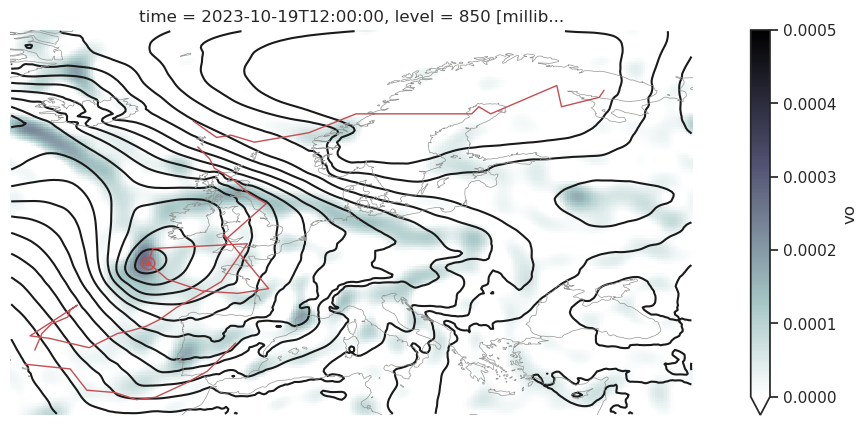

In [18]:
fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(15,5))

choose_time='2023-10-19 12'
contours = 'msl'

if contours == 'msl':
    field_in.sel(time=choose_time).vo.plot(ax=ax,cmap='bone_r',vmin=0,vmax=5e-4)
    field_in.sel(time=choose_time).msl.plot.contour(ax=ax,levels=np.arange(95000,102000,400),colors='k')
    
else:
    field_in.sel(time=choose_time).msl.plot(ax=ax,cmap='bone',vmin=95000,vmax=102000)
    field_in.sel(time=choose_time).vo.plot.contour(ax=ax,levels=np.arange(1e-4,6e-4,1e-4),colors='k')


nodes_out.loc[nodes_out.date==choose_time].plot.scatter('lon','lat',
                                                        color='r',
                                                        s=9,
                                                        ax=ax,
                                                        marker='o')
tracks_out.loc[tracks_out.date==choose_time,['lon','lat']].plot('lon','lat',
                                                                ax=ax,
                                                                ms=9,
                                                                marker='o',
                                                                mec='r',
                                                                mfc='none',
                                                                lw=0, 
                                                                legend=False)
g=sns.lineplot(data=tracks_out.loc[(tracks_out.date>'2023-10-12')&(tracks_out.date<'2023-10-24')],
               x='lon',
               y='lat',
               size='track_id',
               sizes=(1,1),
               color='r',
               legend=False,
               ax=ax,
               estimator=None,
               zorder=11,
               sort=False)

ax.coastlines(color='xkcd:grey',lw=0.5,zorder=10)
ax.axis('off')

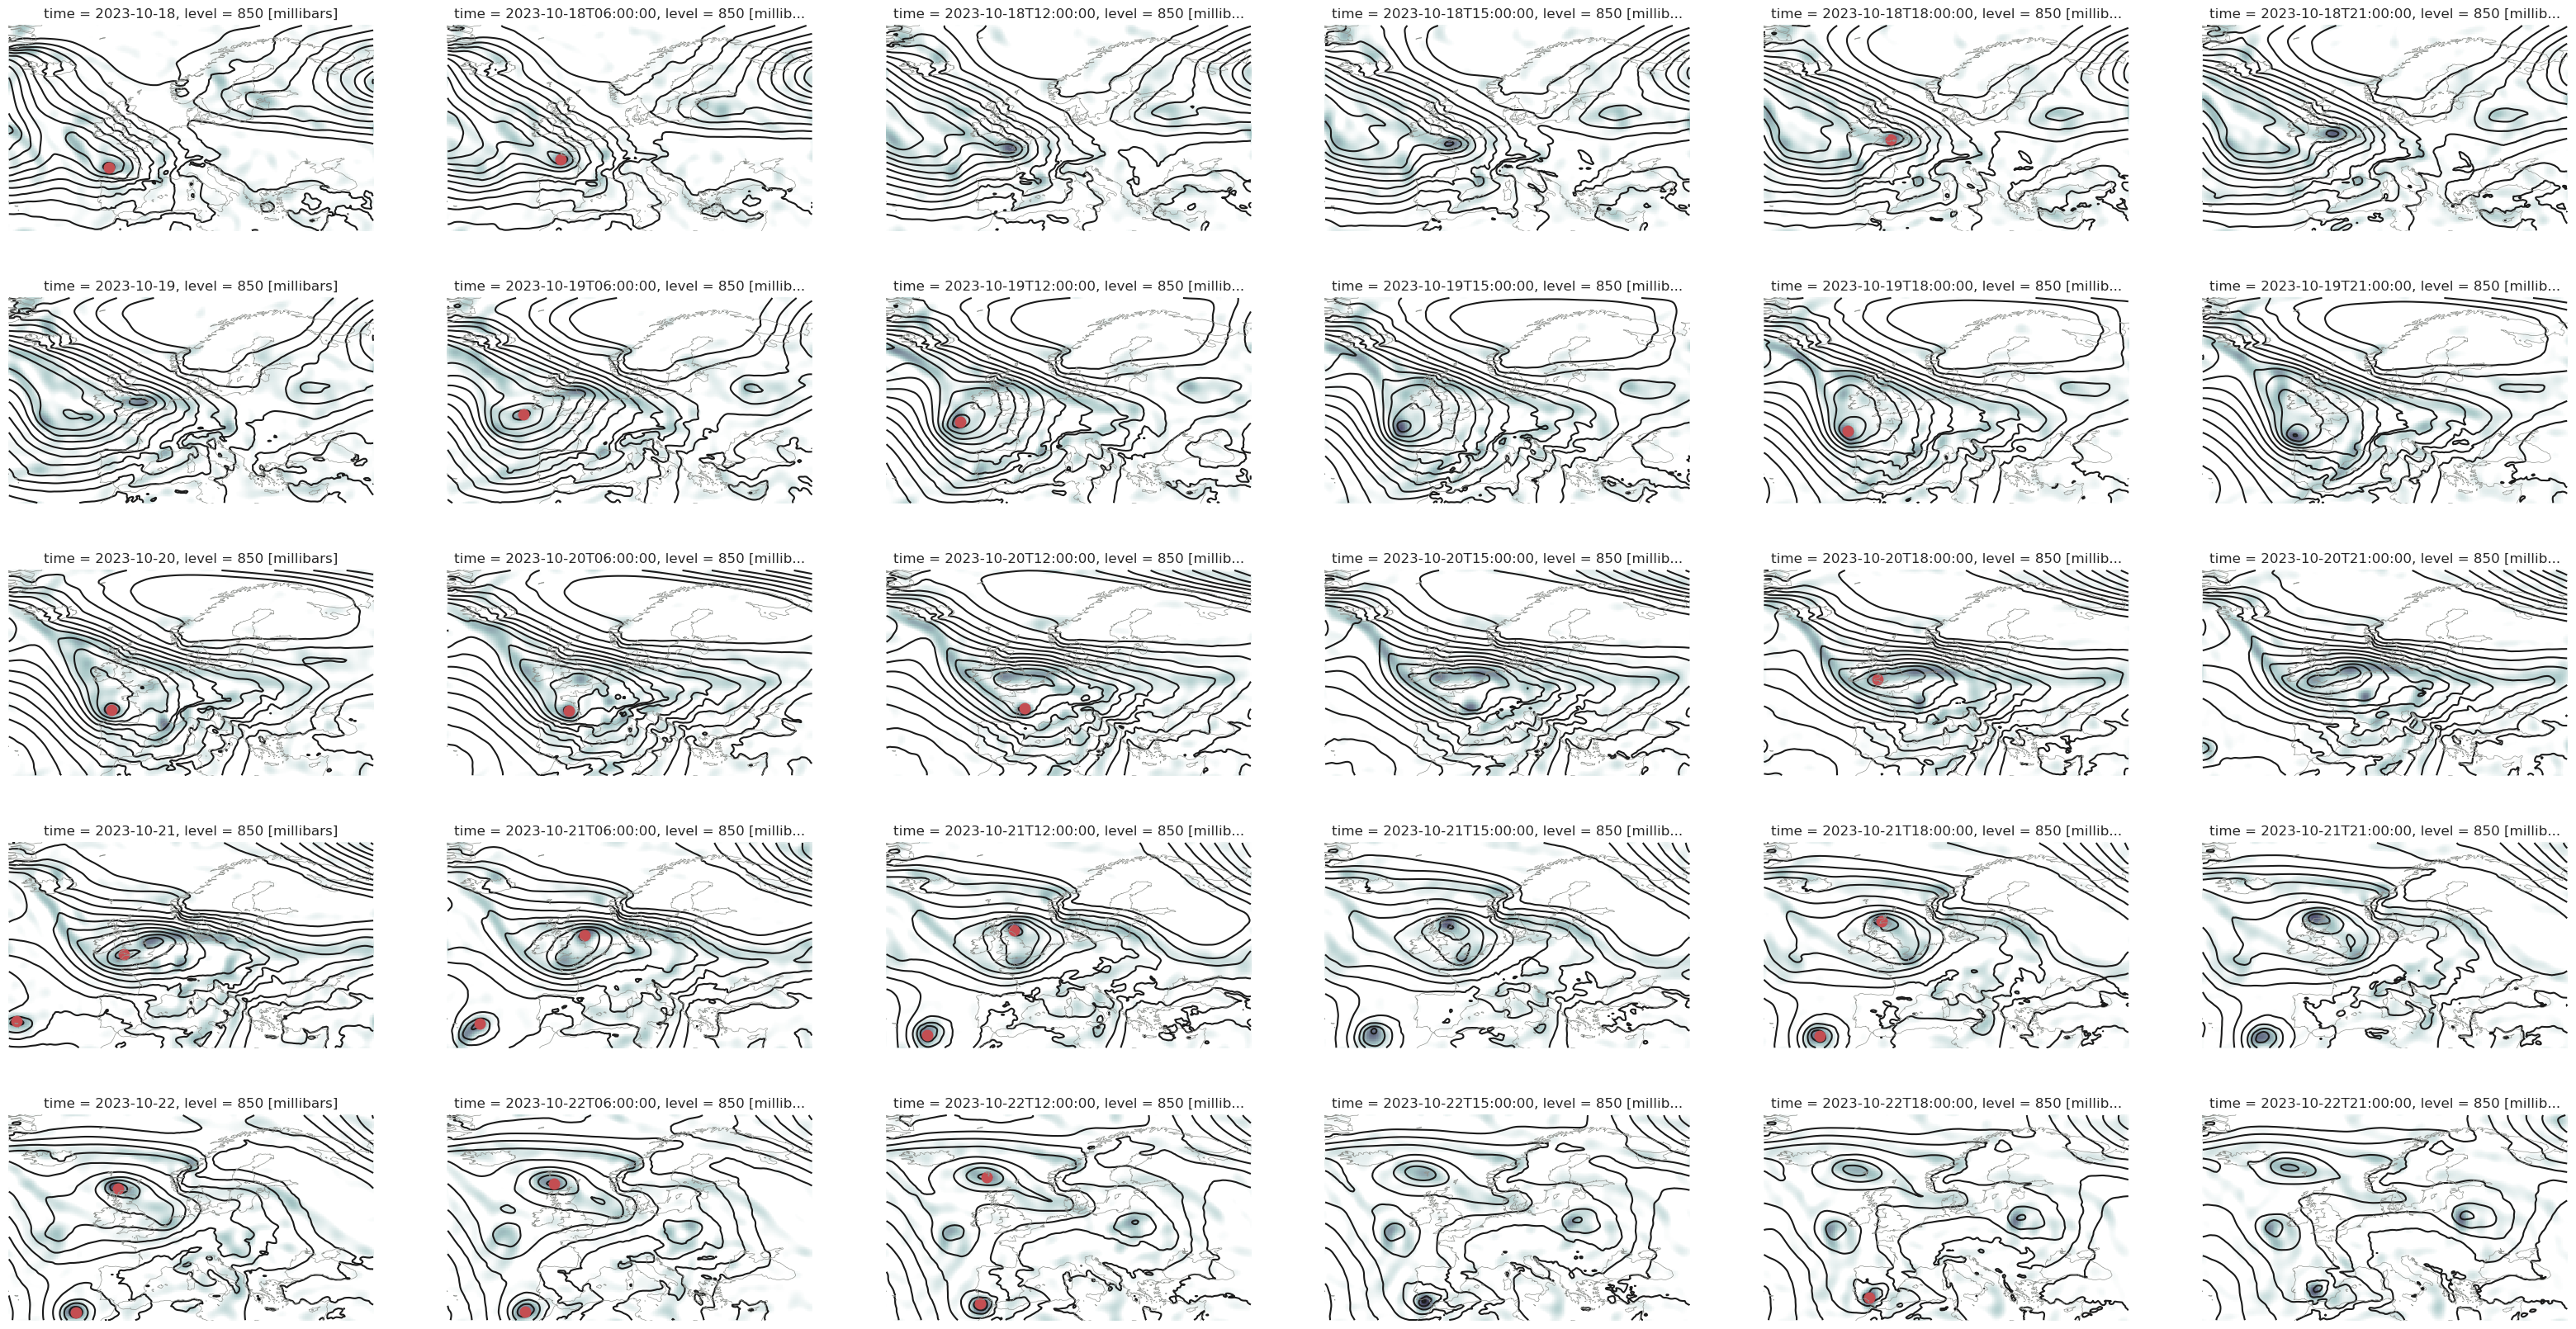

In [19]:
times = ['2023-10-18 00', '2023-10-18 06', '2023-10-18 12', '2023-10-18 15', '2023-10-18 18', '2023-10-18 21',
         '2023-10-19 00', '2023-10-19 06', '2023-10-19 12', '2023-10-19 15', '2023-10-19 18', '2023-10-19 21',
         '2023-10-20 00', '2023-10-20 06', '2023-10-20 12', '2023-10-20 15', '2023-10-20 18', '2023-10-20 21',
         '2023-10-21 00', '2023-10-21 06', '2023-10-21 12', '2023-10-21 15', '2023-10-21 18', '2023-10-21 21',
         '2023-10-22 00', '2023-10-22 06', '2023-10-22 12', '2023-10-22 15', '2023-10-22 18', '2023-10-22 21']
plt.figure(figsize=(40,25))
for i, time in enumerate(times):
    ax = plt.subplot(6,6,i+1,projection=ccrs.PlateCarree())
    field_in.sel(time=time).vo.plot(cmap='bone_r',vmin=0,vmax=5e-4,ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    field_in.sel(time=time).msl.plot.contour(ax=ax,levels=np.arange(95000,102000,400),colors='k', transform=ccrs.PlateCarree(), add_colorbar=False)
    tracks_out.loc[tracks_out.date==time,['lon','lat']].plot('lon','lat',
                                                                ax=ax,
                                                                ms=9,
                                                                marker='o',
                                                                mec='r',
                                                                mfc='r',
                                                                lw=0,
                                                                legend=False)
    ax.coastlines(color='xkcd:grey',lw=0.5,zorder=10)
    ax.axis('off')

# Comparing tracks in curr and ERA5

In [20]:
# functions to convert accumulated variables to conventional ones

## accumulated variables & scaling factors
accumulated_vars = {'tp':60 * 60 * 24 * 1e3,'ttr':1,'tsr':1,'str':1,'ssr':1,'e':1}
accumulated_var_newunits = {'tp':'mm day$^{-1}$','ttr':'W m$^{-2}$','tsr':'W m$^{-2}$','str':'W m$^{-2}$','ssr':'W m$^{-2}$','e':'m s$^{-1}$'}

## definition to convert accumulated variables to instantaneous:
def accum2rate(ds):
    ds = ds.copy()
    oindex = ds.time
    inidate = pd.to_datetime(oindex[0].values)
    
    ds = ds.diff('time') / ( ds.time.diff('time').astype(float) / 1e9 )
    ds = ds.reindex(time=oindex)
    return ds[1:]

In [21]:
# main preprocessing function

def preproc_ds(ds):
    
    ds = ds.copy().squeeze()
    
    fname = ds.encoding['source'].split('/')[-1].split('.')[0]
    
    expver = fname.split('_')[0]
    ds = ds.expand_dims({'experiment':[expver]})
    
    # set up aux data
    inidate = pd.to_datetime(ds.time[0].values)
    
    # expand dimensions to include extra info
    if not 'hDate' in ds:
        ds = ds.expand_dims({'inidate':[inidate]})
        
    if not 'number' in ds:
        ds = ds.expand_dims({'number':[0]})
        
    # put time dimension at front
    ds = ds.transpose('time',...)
    
    # convert accumulated variables into instantaneous
    for var,sf in accumulated_vars.items():
        if var in ds.keys():
            ds[var][1:] = accum2rate(ds[var]) * sf
            # set first value to equal zero [since it should be zero... but isn't always]
            ds[var][0] = 0
            ds[var].attrs['units'] = accumulated_var_newunits[var]
            
    return ds

In [22]:
# need a couple more steps for preprocessing the m-climate

def preproc_mclim(ds):
    
    ds = ds.copy().squeeze()
    
    ds = preproc_ds(ds)
    
    # create index of hours from initialisation
    ds_hours = ((ds.time-ds.time.isel(time=0))/1e9/3600).astype(int)
    # change time coord to hours coord + rename
    ds = ds.assign_coords(time=ds_hours).rename(dict(time='hour'))
    
    return ds

In [23]:
def lagrangian_frame(ds):
    ds = ds.squeeze()
    ds = ds.assign_coords(latitude=ds.latitude-ds.centroid_lat,longitude=ds.longitude-ds.centroid_lon)
    ds = ds.rename(latitude='storm_lat',longitude='storm_lon')
    ds = ds.sel(storm_lon=slice(-10,10),storm_lat=slice(10,-10))
    return ds

In [24]:
def import_medr_tracks_TE(fpath):
    
    df = pd.read_csv(fpath,skipinitialspace=True)
    
    expdict = {'b2rc':'curr','b2rr':'pi','b2re':'incr'}
    
    fname = fpath.split('/')[-1]
    _,expid,inidate,mem = fname.split('_')
    
    df['expid'] = expid
    df['experiment'] = expdict[expid]
    df['inidate'] = pd.to_datetime(inidate)
    df['number'] = int(mem)
    
    return df

In [25]:
import multiprocessing
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(import_medr_tracks_TE, glob.glob('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/TEStitch_2023_0',skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

babet_track = era_track.query('track_id==1')

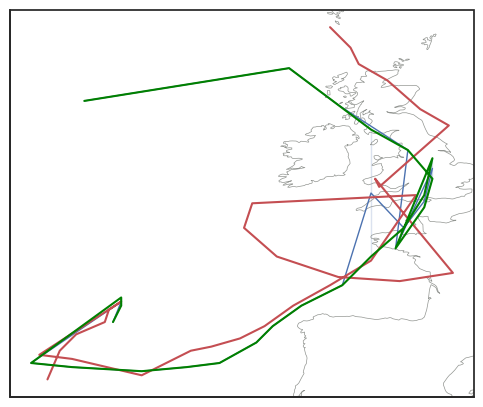

In [26]:

g=sns.relplot(data=ifs_tracks.query('inidate=="2023-10-15" & experiment=="curr" & number==12'),
              x='lon',y='lat',
              size='track_id',
              sort=False,sizes=(1,1),
              kind='line',
              legend=False,
              facet_kws=dict(subplot_kws=dict(projection=ccrs.PlateCarree()))) # the way that this is plotted seems to inaccurate, look at green line instead

# sns.lineplot(data=tracks_out.query('track_id==1'),
#              x='lon',y='lat',
#              legend=False,color='r')
plt.plot(tracks_out.query('track_id==1').lon, tracks_out.query('track_id==1').lat, 
         color='r')

plt.plot(ifs_tracks.query('inidate=="2023-10-15" & experiment=="curr" & number==12').lon, ifs_tracks.query('inidate=="2023-10-15" & experiment=="curr" & number==12').lat, 
         color='green')

g.axes[0,0].coastlines(color='xkcd:grey',lw=0.5)

# Filter tracks for Babet-like storms

In [17]:
# filtering criteria, first brainstorm
# babet_lat = 39.75
# babet_lon = -24.50
# detection_area = [babet_lat-10, babet_lat+10, babet_lon-10, babet_lon+10]
# min_pressure = 96500

In [5]:
# import tracks in parallel with multiprocessing
P1 = multiprocessing.Pool(40)
ifs_tracks = P1.map(bb.lagrange.Lagrange.import_medr_tracks_TE, glob.glob('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/TEStitch_[!2]*'))
P1.close()
ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

In [10]:
# add era track in
era_track = pd.read_csv('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/TEStitch_2023_0',skipinitialspace=True)
era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2023-10-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])
babet_track = era_track.query('track_id==1')

In [14]:
all_tracks.head()

track_id  year month day hour   i    j    lon    lat        msl        vo  \
0        0  2023    10  15    0  20  119 -22.00  43.75  100398.20  0.000250   
1        0  2023    10  15    6  23  118 -21.25  44.00  100233.00  0.000248   
2        0  2023    10  15   12  30  116 -19.50  44.50  100211.30  0.000195   
3        0  2023    10  16    0  10  133 -24.50  40.25   98897.40  0.000223   
4        0  2023    10  16    6  20  129 -22.00  41.25   98101.97  0.000312   

  expid experiment    inidate  number                date  
0  b2rr         pi 2023-10-15      14 2023-10-15 00:00:00  
1  b2rr         pi 2023-10-15      14 2023-10-15 06:00:00  
2  b2rr         pi 2023-10-15      14 2023-10-15 12:00:00  
3  b2rr         pi 2023-10-15      14 2023-10-16 00:00:00  
4  b2rr         pi 2023-10-15      14 2023-10-16 06:00:00

In [16]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min,
                                                                                              day=np.size,
                                                                                              lon = lambda x: x.iloc[0],
                                                                                              lat = lambda x: x.iloc[0],
                                                                                              msl = min))
babet_filter = babet_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min,
                                                                                          day=np.size,
                                                                                          lon = lambda x: x.iloc[0],
                                                                                          lat = lambda x: x.iloc[0],
                                                                                          msl = min)).iloc[0]

babet_filter

date    2023-10-14 06:00:00
day                      31
lon                   -24.5
lat                   39.75
msl                96740.23
Name: (1, 2023-10-01 00:00:00, era5, 0), dtype: object

In [44]:
ifs_tracks_filter

date  day    lon    lat  \
track_id inidate    experiment number                                          
0        2023-10-13 pi         1      2023-10-13 00:00:00   11  -9.00  63.75   
                               2      2023-10-13 00:00:00   10  -5.75  64.25   
                               3      2023-10-13 00:00:00   16  -6.25  64.50   
                               4      2023-10-13 00:00:00   11  -6.00  64.50   
                               5      2023-10-13 00:00:00   10  -6.25  64.25   
...                                                   ...  ...    ...    ...   
2        2023-10-15 incr       3      2023-10-16 00:00:00    8  29.25  48.00   
                               14     2023-10-18 12:00:00    5 -23.00  49.25   
                               41     2023-10-17 06:00:00   11 -12.25  49.50   
3        2023-10-13 pi         38     2023-10-20 12:00:00    5 -11.25  36.75   
         2023-10-15 incr       3      2023-10-18 06:00:00    9 -23.50  46.00   

                                            msl  
track_id inidate    experiment number            
0        2023-10-13 pi         1       95778.89  
                               2       96897.43  
                               3       96431.69  
                               4       97076.43  
                               5       96907.16  
...                                         ...  
2        2023-10-15 incr       3       97940.98  
                               14      95985.20  
                               41      95931.12  
3        2023-10-13 pi         38      97735.20  
         2023-10-15 incr       3       96121.86  

[223 rows x 5 columns]

In [74]:
# starttime criterion - must be detected within 24 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - babet_filter.date).dt.total_seconds().abs()<(24*60*60)

# duration criterion - must last at least 3 days
duration_crit = ifs_tracks_filter.day > 5  # this seems a bit arbitrary

# starting location criterion - must start within 30 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon - babet_filter.lon)**2+(ifs_tracks_filter.lat - babet_filter.lat)**2)<10

# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[minmsl_crit&duration_crit&startloc_crit]

In [75]:
ifs_babet_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [76]:
ifs_babet_list.head()

track_id    inidate experiment  number  year month day hour   i    j  \
0         0 2023-10-15       curr       1  2023    10  15    0  21  119   
1         0 2023-10-15       curr       1  2023    10  15    6  24  119   
2         0 2023-10-15       curr       1  2023    10  15   12  27  116   
3         0 2023-10-15       curr       1  2023    10  16    0  12  130   
4         0 2023-10-15       curr       1  2023    10  16    6  21  127   

     lon    lat        msl        vo expid                date  
0 -21.75  43.75  100302.80  0.000258  b2rc 2023-10-15 00:00:00  
1 -21.00  43.75  100172.10  0.000229  b2rc 2023-10-15 06:00:00  
2 -20.25  44.50  100091.20  0.000211  b2rc 2023-10-15 12:00:00  
3 -24.00  41.00   98823.31  0.000221  b2rc 2023-10-16 00:00:00  
4 -21.75  41.75   98014.34  0.000351  b2rc 2023-10-16 06:00:00

In [77]:
pd.set_option('display.max_rows', None) # show all data in the dataframe

In [79]:
# Check how many simulations have Babet like tracks
count_tracks = ifs_babet_list.groupby(['inidate','experiment','number'])['track_id'].nunique()
count_tracks

inidate     experiment  number
2023-10-13  pi          11        1
                        27        2
                        46        1
                        47        1
                        49        1
2023-10-15  curr        1         1
                        2         1
                        4         1
                        5         1
                        7         1
                        8         1
                        9         1
                        12        1
                        13        1
                        14        1
                        18        1
                        19        1
                        23        2
                        24        2
                        26        1
                        27        1
                        28        1
                        30        1
                        32        1
                        33        1
                        35        1
                        36       

In [70]:
# There are some members with more than one track
# choose the one that is closest to the ERA5 track
multi_track_members = ifs_babet_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')
multi_track_members

year
inidate    experiment number      
2023-10-13 pi         27         2
2023-10-15 curr       2          2
                      9          2
                      23         2
                      24         3
                      49         2
           incr       1          2
                      2          2
                      3          2
                      12         2
                      24         2
                      30         2
                      36         2
                      41         2
                      46         2
                      49         2
           pi         19         2

In [80]:
def babet_dist(df):
    
    babet_lons = babet_track.lon.values
    babet_lats = babet_track.lat.values
    
    track_lons = df.lon.values
    track_lats = df.lat.values
    
    minsize = min(babet_lons.size,track_lons.size)
    
    return np.sqrt((track_lons[:minsize]-babet_lons[:minsize])**2+(track_lats[:minsize]-babet_lats[:minsize])**2).sum()


In [81]:
for idx in multi_track_members.index:
    track_dists = ifs_babet_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(babet_dist)
    num_reject = track_dists.idxmax()
    ifs_babet_list_idx = ifs_babet_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_babet_list = ifs_babet_list.drop(ifs_babet_list_idx)

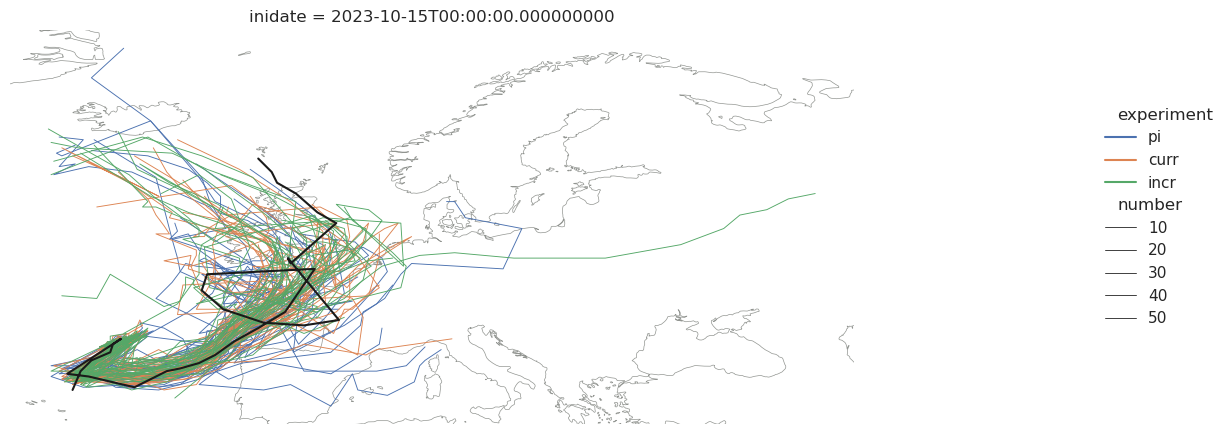

In [90]:
g=sns.relplot(data=ifs_babet_list.loc[ifs_babet_list.inidate.isin(['2023-02-13','2023-10-15'])],
              x='lon',y='lat',
              row='inidate',
              hue='experiment',
              hue_order=['pi','curr','incr'],
            #   palette=get_palette.Petroff6().to_sn_palette(),
              size='number',sort=False,
              estimator=None,
              sizes=(0.66,0.66),
              kind='line',height=4.5,
              legend=True,
              facet_kws=dict(subplot_kws=dict(projection=ccrs.PlateCarree())),
              aspect=3)

# ERA5 track
[plt.plot(babet_track.lon, babet_track.lat, 
         color='k') for a in g.axes.flatten()]

# Add coastlines and remove axis ticks
[a.coastlines(color='xkcd:grey',lw=0.5) for a in g.axes.flatten()]
[a.axis('off') for a in g.axes.flatten()];